# Anime Face Generation
In the final project, you'll learn to define and train a GAN on a dataset of anime faces. The goal is to obtain a generator network to generate images of anime faces that look very cute and cartoon!

The final project includes several tasks, from loading data and training a GAN. At the end of the notebook, you will be able to visualize the results of the trained generator to understand its performance; the samples you generate should look like fairly anime faces with a small amount of noise.

**In this project, we encourage students to think about how to improve the performance of GAN and the stability of training. Students can write the experimental results and analysis into the report. This part will be used as a bonus item.**



## Download the data
You can use this link [Anime Face dataset](https://www.kaggle.com/lunarwhite/anime-face-dataset-ntumlds) to download dataset for training your adversarial networks.

This is an dataset consisting of 36.7k high-quality anime faces. We suggest that you utilize a GPU for training.

In [1]:
#import necessary libraries
import torch, torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch import nn, optim
from torchvision.utils import make_grid
from torchvision.utils import save_image
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image
%matplotlib inline

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

## Visualize the input image
Note that these are color images with 3 color channels (RGB) each.

## Pre-process and Load the Data
Based on the previous knowledge, students are required to complete the code for preprocessing and data loading. 
### For preprocessing 
we recommend students to use `transforms` in `torchvision`. Students are required to fill in at least two items: `Resize` and `CenterCrop`. Students can also try other **data augumentation methods** and display the results in the final report as a **bonus item**.
### Load the Data
In this part, you need define your own `Dataset` to load training images. For GAN, you don't need to load label data. Thus, defining the Dataset is easier than previous assignments.

In [2]:
from google.colab import drive
drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [3]:
cd 'gdrive/MyDrive/Colab'

/content/gdrive/MyDrive/Colab


In [4]:
#pwd
files = os.listdir()
print(files)

['data.h5', 'Untitled', 'img', 'generated', 'checkpoint', 'project_GAN_martti_2.ipynb']


In [5]:
# Create h5py file for images for faster processing in Google Colab
# Source: https://medium.com/@oribarel/getting-the-most-out-of-your-google-colab-2b0585f82403

skip = 1

if skip == 0:
  if os.path.exists('data.h5') == 0:
      fileName = 'data.h5'
      allimgs = []
      #fileNames = os.listdir(path)
      for i in range(0, len(fileNames)):
          img = Image.open(path + fileNames[i])      # X_train_1.jpg is 256 x 256 RGB image
          img = np.asarray(img)
          allimgs.append(img)
          
      with h5py.File(fileName, "a") as out:
              out['Xtrain'] = allimgs

In [6]:
#TODO: Create your own Preprocessing methods
#The batch_size is defined by yourself based on the memory of GPU or CPU.

# Tutorial for colab: https://medium.com/@oribarel/getting-the-most-out-of-your-google-colab-2b0585f82403

import h5py
fname = 'data.h5'
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
imgSize = 64
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(imgSize),
                                transforms.CenterCrop(imgSize),
                                transforms.Normalize(*stats)])
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
#TODO: Complete the loading data including Dataset and Dataloader.
class AnimeData(Dataset):
    """
    Wrap the data into a Dataset class, and then pass it to the DataLoader
    :__init__: Initialization data
    :__getitem__: support the indexing such that dataset[i] can be used to get ith sample
    :__len__: return the size of the dataset.
    """
    def __init__(self, in_file, transform=None):
        super(AnimeData, self).__init__()

        self.file = h5py.File(in_file, 'r')
        self.transform = transform
    def __len__(self):
        return self.file['Xtrain'].shape[0]
    
    def __getitem__(self, idx):
        img = self.file['Xtrain'][idx, ...]

        # Preprocessing each image
        if self.transform is not None:
            img = self.transform(img)

        return img

#TODO: Complete the trainloader 
batch_size = 128
trainset = AnimeData(fname, transform=transform)
trainloader = DataLoader(trainset, batch_size, shuffle=True, num_workers=0)

#TODO：randomly choose images to visualize
    
print("TRAINING DATASET SIZE TEST")
for i, sample in enumerate(trainloader):
    show_images(sample, nmax=64)
    if i == 3:
        break

Output hidden; open in https://colab.research.google.com to view.

## Check your device and move data to device
In this part, students can check whether the computer's GPU is available and move the data to the GPU (or CPU). We strongly recommend that students use GPU to speed up the program. 

`torch.cuda.is_available` can help us to check whether GPU is available.

In [7]:
if torch.cuda.is_available():
    device=torch.device('cuda')
    print("GPU in use")
else:
    device=torch.device('cpu')
    print("CPU in use")

GPU in use


## Define a GAN
A GAN consists of two adversarial networks, a discriminator and a generator.
### Discriminator
Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. 
#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 3x64x64 tensor images
* The output should be a single value that will indicate whether a given image is real or fake

An example of our discriminant model is as follows, and students can also define it by themselves, including adjusting the model structure and activation function. We recommend that students use `nn.Sequential` to define the model, which is more simple and intuitive.
<img src='./img/d.png' width=80% />

**Students can build models based on examples, but we suggest you try different models (including model structure and activation function). This will be regared as a bonus.**

In [8]:
#TODO: Create your Discriminator model
class Discriminator(nn.Module):
    def __init__(self,inchannels):
        super(Discriminator,self).__init__()
        """
        Initialize the Discriminator Module
        :param inchannels: The depth of the first convolutional layer
        """
        
        self.discriminator = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace = True), 

        nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding = 1, bias = False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace = True),
            
        nn.Conv2d(512, 1, kernel_size = 4, stride = 1, padding = 0, bias = False),
        nn.Flatten(),
        nn.Sigmoid()
    )

    def forward(self,x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        
        x = self.discriminator(x)
        
        return x
        
D=Discriminator(3).to(device)


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `3x64x64`. This should be mostly transpose convolutional layers `nn.ConvTranspose2d` with normalization applied to the outputs.

#### Exercise: Complete the Generator model
* The inputs to the generator are vectors of some length `latent_size`
* The output should be a image of shape `3x64x64`

The example of Generator is as follows. 
<img src='./img/g.png' width=80% />

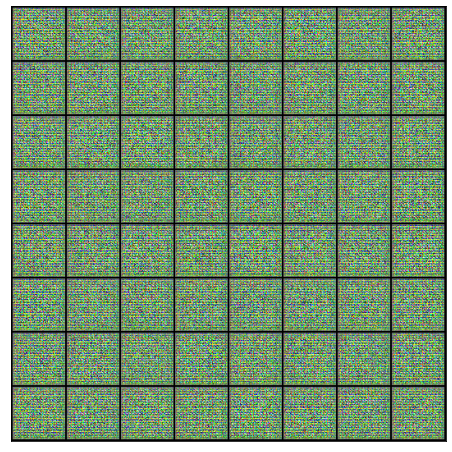

In [9]:
#TODO: Create your Generator model
latent_size = 128
class Generator(nn.Module):
    def __init__(self,latent_size):
        super(Generator,self).__init__()
        """
        Initialize the Generator Module
        :param latent_size: The length of the input latent vector
        """
        self.generator = nn.Sequential(
        nn.ConvTranspose2d(in_channels=latent_size, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        
        nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        
        nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        
        nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh()
        )
        
    def forward(self,x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 3x64x64 Tensor image as output
        """
        
        x = self.generator(x)
        
        return x
        
G=Generator(latent_size).to(device) 
# random latent tensors
noise = torch.randn(batch_size, latent_size, 1, 1).to(device)
#TODO: use generator model to generate fake image 
fake_images = G(noise).to(device)
#TODO: visualize the fake images by function show_images
show_images(fake_images.cpu())
#show_images(fake_images)

---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions. We also encourage students to use the loss function in other related papers as a bonus item. If you use it, please include a citation in the report**

In [10]:
#TODO：Complete the loss function for training GAN
def Real_loss(preds,targets):
    '''
       Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss
    '''
    loss = nn.functional.binary_cross_entropy(preds, targets)
    return loss
def Fake_loss(preds,targets):
    '''
       Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss
    '''
    loss = nn.functional.binary_cross_entropy(preds, targets)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [11]:
# Create optimizers for the discriminator D and generator G
# https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/

#Define your learning rate
lr=0.0002
opt_d = torch.optim.Adam(D.parameters(), lr=lr/2, betas=(0.5, 0.999),weight_decay = 0.0005)
opt_g = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999),weight_decay = 0.0005)

### Save the generated images
This code can help you save images generated from Generator G

In [12]:
##Define your save path.
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)
def save_samples(index, latent_tensors, generator, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
        plt.show()
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

## Training GAN to generate anime faces
Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [13]:
import random

#TODO: Complete the training function
losses_g = []
losses_d = []
real_scores = []
fake_scores = []
def train(D, G, d_optimizer, g_optimizer, epochs=1, device='cpu'):
    
    # INPUTS
    # D: discriminator network
    # G: Generator network
    # d_optimzer: optimizer for discriminator
    # g_optimizer: optimizer for generator
    # epochs
    
    iter_count = 0
    start_idx=1
    for epoch in range(epochs):
        epoch_real_D_loss = []
        epoch_fake_D_loss = []
        epoch_G_loss = []
        epoch_real_scores = []
        epoch_fake_scores = []
        for real_images in tqdm(trainloader):
            real_images=real_images.to(device)
            # -----------------------------------------------
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # -----------------------------------------------
            # 1. Train the discriminator on real and fake images

            # Clear gradients of discriminator
            d_optimizer.zero_grad()

            # Pass real images through discriminator
            real_predictions = D(real_images)
            # Label smoothing with small noise, close to one
            real_labels = torch.ones_like(real_predictions).to(device) - random.uniform(0, 0.1) # Random numbers from 0 to 0.1 created (real labels: 0.9 - 1)
            real_loss = Real_loss(real_predictions, real_labels)
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1).to(device)
            fake_images = G(latent)
            
            # Pass fake images through discriminator
            fake_predictions = D.discriminator(fake_images)

            # Label smoothing with small noise, close to zero
            fake_labels = torch.zeros(fake_images.size(0), 1, device=device)
            fake_loss = Fake_loss(fake_predictions, fake_labels)
            
            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            d_optimizer.step()
            
            ## 2. Train the generator with an adversarial loss
            # Generate fake images
            latent = torch.randn(batch_size ,latent_size, 1, 1, device=device)
            fake_images = G.generator(latent)

            # Clear gradients of generator
            g_optimizer.zero_grad()
            
            # Try to fool the discriminator
            fake_predictions_2 = D.discriminator(fake_images)
            fake_labels_2 = torch.ones(fake_images.size(0), 1, device=device)
            loss_g = Fake_loss(fake_predictions_2, fake_labels_2)
            # Update generator weights
            loss_g.backward()
            g_optimizer.step()

        real_score = torch.mean(real_predictions).item()
        fake_score = torch.mean(fake_predictions).item()
        losses_g.append(loss_g.item())
        losses_d.append(loss_d.item())
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent,G, show=True)
            
        state_dis = {'dis_model': D.state_dict(), 'epoch': epoch}
        state_gen = {'gen_model': G.state_dict(), 'epoch': epoch}
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint') 
        torch.save(state_dis, 'checkpoint/'+'D__'+str(epoch+1)) #each epoch
        torch.save(state_gen, 'checkpoint/'+'G__'+str(epoch+1)) #each epoch
#Train the GAN
train(D,G,opt_d,opt_g,epochs=40, device=device)

Output hidden; open in https://colab.research.google.com to view.

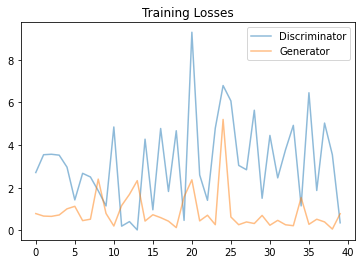

In [14]:
##Visualize your loss curve of D and G
fig, ax = plt.subplots()
plt.plot(losses_g, label='Discriminator', alpha=0.5)
plt.plot(losses_d, label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

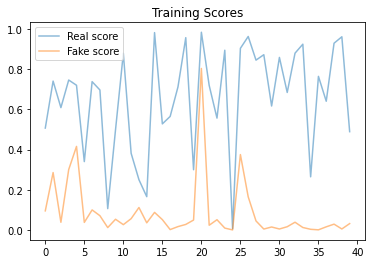

In [15]:
fig, ax = plt.subplots()
plt.plot(real_scores, label='Real score', alpha=0.5)
plt.plot(fake_scores, label='Fake score', alpha=0.5)
plt.title("Training Scores")
plt.legend()

### Question1: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result

###### Answer:

By pure observational point of view, some clear deficts are visible in the generated samples although project objective of creating fairly anime face looking samples was reached. The details such as eyes, mouth and nose seem to be biggest struggle with the generated samples. Some faces have eyes "melted" away and some mismatched eyes. However, there are also real looking samples among.

Thus most likely the model should learn better these exact features. This could be achieved by a deepening the network, as then the amount of features to be learnt in the feature space would increase. The optimizer has worked fairly well, and according to literature Adam optimizer with small learning rate has been suitable with GAN. [1]. Also number of epochs was fairly large, however experimenting with very large epoch number when computational resources are sufficient could yield better results.

Sources:

[1] Radford A., et al., "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks
", 2015, https://arxiv.org/abs/1511.06434

### Question2: How does the training loss of the generator and the discriminator change during your training?

###### Answer:

The genreator loss stabilizes toward end of the training, but discriminator loss continues zig-zag behaviour until the end. Discriminator is having hard time adjusting to the improving generator and thus the losses won't dimnish as the training progresses.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "final_project_StudentNumber_StudentName.ipynb". Include the generated images in your submission.